# Implement kmeans algorithms

## This naive implementation assumes that input datasets are pandas dataframes.

## kmeans_distance function

The first equation implements the function to calculate the distance between the data and the centroid. This function calculates the L2 distance metric between each data points and the centroid. It returns a pandas dataframe with each row being the cluster number, and each column being the distance of each data point to the centroid.


The inputs are 
1. data is the input pandas dataframe.
2. centroid is the current centroid position.
3. n_cluster is the number of clusters.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# assume centroid and data are pandas dataframe 
# data is the input data
# centroid is the current centroid position.
# n_cluster is the number of clusters.

def kmeans_distance(data,centroid,n_cluster):
    # initialize the data frame to be all zeros to hold the distance value.
    # each row is the cluster number, each column is the distance of each data point to the centroid.
    distance_df = pd.DataFrame(index=range(n_cluster),columns= data.index)
    distance_df = distance_df.fillna(0)
    
    # assign the value of L2 norm distance to the centroid to each row of the distance_df
    for i in range(centroid.shape[0]):
        distance_df.iloc[i] = np.square(data-centroid.iloc[i]).sum(axis=1)
        
    # return the distance dataframe 
    return distance_df  

## kmeans_iter function

This function implements one interation of the kmeans clustering, which updates the current centroid poistion. It will first calculate the distance of all data to the current centroids, and assign new cluster numbers based on the L2 distance. Then, it will calculate the new cluster center using the the means.  

The inputs are 
1. data is the input pandas dataframe
2. centroid is the current centroid position.
3. n_cluster is the number of clusters.

In [3]:

def kmeans_iter(data,centroid,n_cluster):
    # calculate the distance matrix 
    distance_dataframe = kmeans_distance(data,centroid,n_cluster)
    
    # calculate the current new cluster assignments.
    new_cluster_assignment = [0]*data.shape[0]
    for index in range(len(new_cluster_assignment)):
        
        new_cluster_assignment[index] = distance_dataframe.iloc[:,index].idxmin()
    # finished with cluster assignment, the cluster labels are now in a list.
    
    # initialize the dataframe to store new centroid positions.
    new_centroid = pd.DataFrame(index= range(n_cluster),columns = data.columns)
    # initialize a list to store the within cluster variance to measure if the cluster converges. 
    new_centroid_variance = [0]*n_cluster
    
    # iterate through all possible cluster number, and calculates the new centroid positions using the mean.  
    for cluster_value in range(n_cluster):
        # get the index for new cluster assignment.
        cluster_data_index = [new_cluster_value_index for new_cluster_value_index,new_cluster_value in enumerate(new_cluster_assignment) if new_cluster_value == cluster_value]
        # get the data belonging to cluster "cluster_value"
        cluster_data = data.iloc[cluster_data_index]
        # calculate the centroid position using the mean for each feature.
        new_centroid_position = cluster_data.mean(axis=0)
        # calculate the within-cluster variance. 
        new_centroid_variance[cluster_value] = cluster_data.var(axis = 0).sum(axis = 0)
        # assign this value to the value for the new_centroid positions.
        new_centroid.iloc[cluster_value] = new_centroid_position
        
    total_clusters_variance = sum(new_centroid_variance)

    return total_clusters_variance, new_centroid

## kmeans function

This function implements one entire kmeans clustering iterations. It will initialize the positions with random integers in the range of the maximum and minimum value of the entire data. Then, it will update the positions of the centroid until the tolerance is met or maximum number of interations is reached. 

In [33]:
from tqdm import tqdm
def kmeans(data,n_cluster,max_iter=100, tol = 10**(-5)):
    # initialize the position with some random value.
    new_positions = pd.DataFrame(np.random.randint(data.min().min(),data.max().max(),size=(n_cluster, data.shape[1])),index= range(n_cluster),columns = data.columns)
    
    for i in tqdm(range(max_iter)):
        # create a new copy of the centroid positions
        old_centroids_positions = new_positions.copy()
        # do one iteration of the kmeans algorithm and return the variance of the centroids and new centroid positions.
        new_centroids_variances, new_positions = kmeans_iter(data,old_centroids_positions,n_cluster)
        
        
        # test to see if the new position contains any NA values.
        # if it contains NA values then you need to re-initialize the centroid positions. 
        if new_positions.isnull().sum().sum() !=0:
            new_positions = pd.DataFrame(np.random.randint(data.min().min(),data.max().max(),size=(n_cluster, data.shape[1])),index= range(n_cluster),columns = data.columns)
            
        
        # calculate the squared differences in the cnetroid position change after one iterations.
        positions_sq_diff = np.square(old_centroids_positions-new_positions).sum(axis=0).sum()
        
        # if the change in the squared difference is smaller than the tol value then the iteration is stopped.
        if positions_sq_diff < tol: 
            break
            
      
    return new_positions

## Compare my algorithm with the KMeans implementation in sklearn with two test cases.

In [34]:
test_data2 = pd.DataFrame([[-1,1],[1,-1],[1.01,-1.01]
                           ,[-1.01,1.01],[1.02,-1.02]
                           ,[-1.02,1.02],[1.03,-1.03]
                           ,[-1.03,1.03]], columns = ["f1",'f2'])


test_data3 = pd.DataFrame([[-1,1,-1],[1,-1,1]
                           ,[1.01,-1.01,1.01]
                           ,[-1.01,1.01,-1.01]
                           ,[1.02,-1.02,1.02]
                           ,[-1.02,1.02,-1.02]
                           ,[1.2,-1.2,1.2]
                           ,[-1.2,1.2,-1.2]], columns = ["f1",'f2','f3'])

In [35]:
kmeans(test_data2,2)

  0%|          | 0/100 [00:00<?, ?it/s]


,f1,f2
0,-1.015,1.015
1,1.015,-1.015


In [36]:
kmeans(test_data3,2)

  0%|          | 0/100 [00:00<?, ?it/s]


,f1,f2,f3
0,1.0575,-1.0575,1.0575
1,-1.0575,1.0575,-1.0575


The result from the Kmeans implementation in sklearn.

In [8]:
from sklearn.cluster import KMeans

KMeans(n_clusters=2, random_state=0).fit(test_data2).cluster_centers_

array([[ 1.015, -1.015],
       [-1.015,  1.015]])

In [9]:
KMeans(n_clusters=2, random_state=0).fit(test_data3).cluster_centers_

array([[ 1.0575, -1.0575,  1.0575],
       [-1.0575,  1.0575, -1.0575]])

# Apply the Kmeans algorithm implemented in image compression.

Import the image data into pandas dataframe

In [60]:
from PIL import Image
im = Image.open('./watchtower/peppers.tiff')

Let us look at the original data.

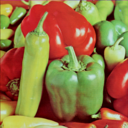

In [67]:
im

Convert the data into numpy array.

In [61]:
image = np.array(im)

Reshape the data for furthur processing. 

In [62]:
image_reshaped = image.reshape(image.shape[0]*image.shape[1],3)

Convert the numpy array to pandas dataframe

In [40]:
image_reshaped = pd.DataFrame(image_reshaped)

Apply our own Kmeans implementation with a cluster size of 16. 

In [41]:
centroids = kmeans(image_reshaped,16)

100%|██████████| 100/100 [05:48<00:00,  3.51s/it]


This is the result for centroids of the clusters. 

In [42]:
centroids

,0,1,2
0,52,209,137
1,99,107,83
2,173,180,226
3,229,151,173
4,124,1,169
5,184,86,155
6,226,195,108
7,158,186,11
8,124,146,48
9,116,53,97


Define a function to assign data to centroids and return the dataframe for the compressed image.

The first function generates the cluster labels based on the centroids positions. 

In [50]:
def new_cluster_labels(data,centroids,n_cluster):
    # calculate the distance matrix 
    distance_dataframe = kmeans_distance(data,centroids,n_cluster)
    
    # calculate the current new cluster assignments.
    new_cluster_assignment = [0]*data.shape[0]
    for index in range(len(new_cluster_assignment)):
        
        new_cluster_assignment[index] = distance_dataframe.iloc[:,index].idxmin()
    
    return new_cluster_assignment

The second function uses the first function that generates the cluster labels to generate the pandas dataframe for the compressed image by replacing the original coloring with the color for the centroids. 

In [53]:
def compressed_img_data(data,centroids,n_cluster):
    # generate the cluster labels from the distance metric.
    cluster_labels = new_cluster_labels(data,centroids,n_cluster)
    
    # initialize new dataframe for storing the compressed data
    new_compressed_img_data = pd.DataFrame(index= range(data.shape[0]),columns = data.columns)
    for index, cluster_label in enumerate(cluster_labels):
        new_compressed_img_data.iloc[index] = centroids.iloc[cluster_label]
    
    return new_compressed_img_data

Generate the pandas dataframe that contains the color for the compressed image, 

In [55]:
compressed_img = compressed_img_data(image, centroids,16)

Convert the pandas dataframe back to the numpy array for conversion into the image.

In [59]:
compressed_img = compressed_img.values

Reshape the numpy array into original format. 

In [63]:
compressed_img_reshaped = compressed_img.reshape(image.shape[0],image.shape[1],3)

This is the compressed image data.

In [64]:
compressed_img_reshaped

array([[[203,  94,  79],
        [203,  94,  79],
        [203,  94,  79],
        ...,
        [226, 195, 108],
        [226, 195, 108],
        [124, 146,  48]],

       [[203,  94,  79],
        [203,  94,  79],
        [203,  94,  79],
        ...,
        [226, 195, 108],
        [226, 195, 108],
        [124, 146,  48]],

       [[203,  94,  79],
        [203,  94,  79],
        [203,  94,  79],
        ...,
        [226, 195, 108],
        [124, 146,  48],
        [124, 146,  48]],

       ...,

       [[124, 146,  48],
        [124, 146,  48],
        [124, 146,  48],
        ...,
        [226, 195, 108],
        [226, 195, 108],
        [226, 195, 108]],

       [[124, 146,  48],
        [124, 146,  48],
        [124, 146,  48],
        ...,
        [173, 180, 226],
        [173, 180, 226],
        [173, 180, 226]],

       [[124, 146,  48],
        [124, 146,  48],
        [124, 146,  48],
        ...,
        [173, 180, 226],
        [173, 180, 226],
        [173, 180, 226]]

Convert the numpy array back to the image. 

## This is the compressed image 

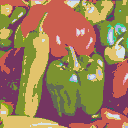

In [66]:
Image.fromarray(compressed_img_reshaped.astype(np.uint8))

## The original image is shown below

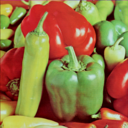

In [69]:
im